In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as ss
from tqdm import tqdm,trange
import geopandas as gpd
from pygris.utils import shift_geometry, erase_water

import sys
sys.path.append('../d03_src/')
import vars
import process_census as prc
import evaluation as eval
import visualization as viz

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)
plots_dir = '../plots/'

# Visualizing the Flows

In this notebook we look into the estimates:
- What are out-flow, in-flow, and net-flow trends nationally?
- What about trends in major cities?
- How do these trends stratify according to demographics?

## 1. Collecting the Data

Collect membership matrices and indices:

In [2]:
_geographies = ['blockgroup', 'tract', 'county', 'state']
C_dict = {}
for fine_idx, fine_geography in enumerate(_geographies):
    for coarse_geography in _geographies[1+fine_idx:]:
        C_dict[(fine_geography, coarse_geography)] = prc.get_geography_matrices(fine_geography,
                                                                                coarse_geography,
                                                                                ignore_PR=True)

Collect the estimates:

In [3]:
M_dict = {year: ss.load_npz(f"{vars.MIGRATE_dir}{year}_{vars.MIGRATE_str}.npz") for year in trange(2011, 2020)}
for y, M in M_dict.items(): assert not (M < 0).nnz, f'Negative entries in {y} matrix'

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.69s/it]


Collect county-to-county and state-to-state flows (indexed by final year):

In [4]:
county_idx = prc.get_geography_indices('county', ignore_PR=True)
F_dict, Fhat_dict = {'state':{}, 'county':{}}, {'state':{}, 'county':{}}
for year in range(2011,2020):
    F_dict['state' ][year], Fhat_dict['state' ][year] = prc.get_ACS1_state_to_state(  year, ignore_PR=True)
    F_dict['county'][year], Fhat_dict['county'][year] = prc.get_ACS5_county_to_county(year, ignore_PR=True)

Collect population and demographics at the CBG and county level:

In [5]:
ACS_CBG_pop = prc.get_demographics(features=('Total', 'Population'), geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])
ACS_CBG_dem = prc.get_demographics(geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])
ACS_county_dem = prc.get_demographics(geography='COUNTY', ignore_PR=True, years=[y for y in range(2010,2020)])

The 2010 Census population can be used as a normalizing factor on national flows and to filter low-population CBGs:

In [6]:
population_threshold = 100
CBG_2010 = prc.get_census2010_CBG_demographics('Population', ignore_PR=True)
CBG_idx = prc.get_geography_indices('blockgroup', ignore_PR=True)
low_population_CBGs = CBG_2010 < population_threshold

## 2. National Flows

In [7]:
vmax_flows = 200

The US gdf may take some time to load:

In [8]:
us_gdf = shift_geometry(gpd.read_file(f'{vars._census_spatial_dir}processed/BLOCK_GROUP.gpkg'))
us_gdf['idx'] = us_gdf.GEOID.astype(int).map(CBG_idx)
us_gdf = us_gdf.dropna(axis=0, subset='idx').sort_values('idx')
assert us_gdf.idx.iloc[-1] == len(us_gdf)-1, 'Missing indices!'

county_gdf = shift_geometry(gpd.read_file(f'{vars._census_spatial_dir}processed/COUNTY.gpkg'))
county_gdf['idx'] = county_gdf.GEOID.astype(int).map(county_idx)
county_gdf = county_gdf.dropna(axis=0, subset='idx').sort_values('idx')
assert county_gdf.idx.iloc[-1] == len(county_gdf)-1, 'Missing indices!'

Mask CBGs:

In [9]:
mask = us_gdf[low_population_CBGs].reset_index(drop=True)

Collect flows and rates:

In [10]:
flow = {'out': {y-1:np.array(M.sum(axis=1)).flatten() - M.diagonal() for y,M in M_dict.items()},
        'in':  {y:  np.array(M.sum(axis=0)).flatten() - M.diagonal() for y,M in M_dict.items()}}
flow_rate = {'out': {y-1: (np.array(M.sum(axis=1)).flatten() - M.diagonal())/np.array(M.sum(axis=1)).flatten() for y,M in M_dict.items()},
             'in':  {y:   (np.array(M.sum(axis=0)).flatten() - M.diagonal())/np.array(M.sum(axis=0)).flatten()  for y,M in M_dict.items()}}
flow_avg = {flow_direction: pd.DataFrame(flow_dict).mean(axis=1).values for flow_direction, flow_dict in flow_rate.items()}

ACS_flow = {'out': {y-1:np.array(F.sum(axis=1)).flatten() - F.diagonal() for y,F in F_dict['county'].items()},
            'in':  {y:  np.array(F.sum(axis=0)).flatten() - F.diagonal() for y,F in F_dict['county'].items()}}
ACS_flow_rate = {'out': {y-1: (np.array(F.sum(axis=1)).flatten() - F.diagonal())/np.array(F.sum(axis=1)).flatten() for y,F in F_dict['county'].items()},
                 'in':  {y:   (np.array(F.sum(axis=0)).flatten() - F.diagonal())/np.array(F.sum(axis=0)).flatten() for y,F in F_dict['county'].items()}}
ACS_flow_avg = {flow_direction: pd.DataFrame(flow_dict).mean(axis=1).values for flow_direction, flow_dict in ACS_flow_rate.items()}

/share/pierson/tmp_directory_location_please_read_readme/gs665_tmp/ipykernel_2177004/3700067394.py:9: RuntimeWarning: invalid value encountered in divide
  ACS_flow_rate = {'out': {y-1: (np.array(F.sum(axis=1)).flatten() - F.diagonal())/np.array(F.sum(axis=1)).flatten() for y,F in F_dict['county'].items()},
/share/pierson/tmp_directory_location_please_read_readme/gs665_tmp/ipykernel_2177004/3700067394.py:10: RuntimeWarning: invalid value encountered in divide
  'in':  {y:   (np.array(F.sum(axis=0)).flatten() - F.diagonal())/np.array(F.sum(axis=0)).flatten() for y,F in F_dict['county'].items()}}


### 2a. National Out-Migration

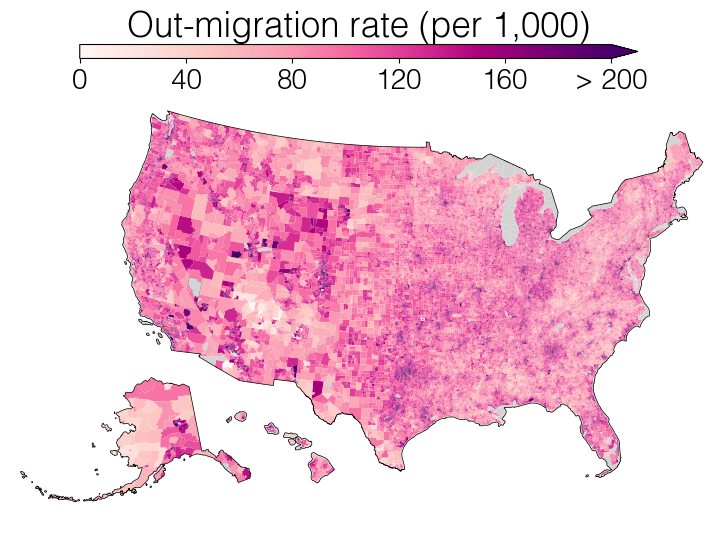

In [11]:
ax = viz.map(1_000*flow_avg['out'], us_gdf=us_gdf, annotate_format=int, vmax=vmax_flows,
             title='Out-migration rate (per 1,000)',
             colorbar_placement=[.1, 1., .8, .1],
             mask=mask)
plt.savefig(f'{plots_dir}flows-nation-out.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}flows-nation-out.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 2b. National In-Migration

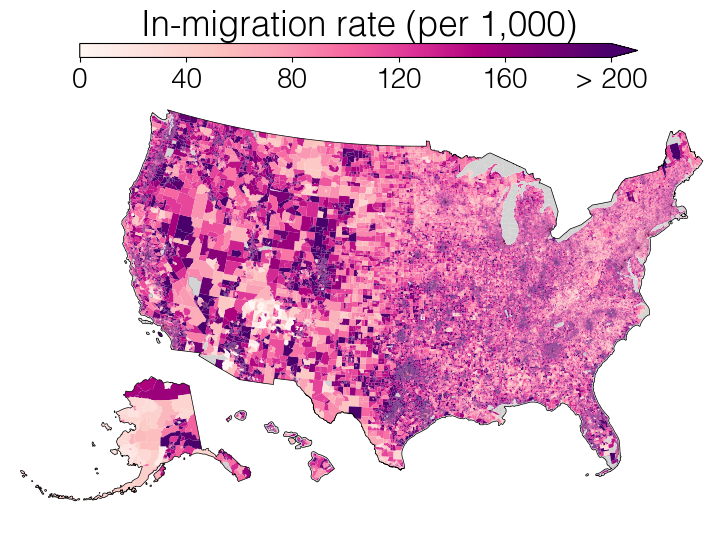

In [12]:
ax = viz.map(1_000*flow_avg['in'], us_gdf=us_gdf, annotate_format=int, vmax=vmax_flows,
             title='In-migration rate (per 1,000)',
             colorbar_placement=[.1, 1., .8, .1],
             mask=mask)
plt.savefig(f'{plots_dir}flows-nation-in.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}flows-nation-in.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Out-flows in major cities

Here are a few cities we can use as example---we report only for New York:

In [13]:
example_cities = {'CBG':{'New York': pd.Series(CBG_idx)[pd.Series(CBG_idx).index.astype(str).str.startswith(('36061', '36047', '36081', '36005', '36085'))].values,
                         'San Francisco': pd.Series(CBG_idx)[pd.Series(CBG_idx).index.astype(str).str.startswith(('6075'))].values,
                         'Chicago': pd.Series(CBG_idx)[pd.Series(CBG_idx).index.astype(str).str.startswith('17031')].values,
                         'Austin':pd.Series(CBG_idx)[pd.Series(CBG_idx).index.astype(str).str.startswith('48453')].values},
                'county':{'New York': pd.Series(county_idx)[pd.Series(county_idx).index.astype(str).str.startswith(('36061', '36047', '36081', '36005', '36085'))].values,
                         'San Francisco': pd.Series(county_idx)[pd.Series(county_idx).index.astype(str).str.startswith(('6075'))].values,
                         'Chicago': pd.Series(county_idx)[pd.Series(county_idx).index.astype(str).str.startswith('17031')].values,
                         'Austin':pd.Series(county_idx)[pd.Series(county_idx).index.astype(str).str.startswith('48453')].values}}

### 3a. Migration in New York City

Collect the boundary:

In [14]:
NYC_boundary = erase_water(county_gdf.iloc[example_cities['county']['New York']])
NYC_mask = erase_water(mask[mask['idx'].isin(example_cities['CBG']['New York'])])
NYC_colorbar = [.2, 0, .8, .1]

/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 33 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 11 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


Out-migration (MIGRATE and county):

/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 25 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


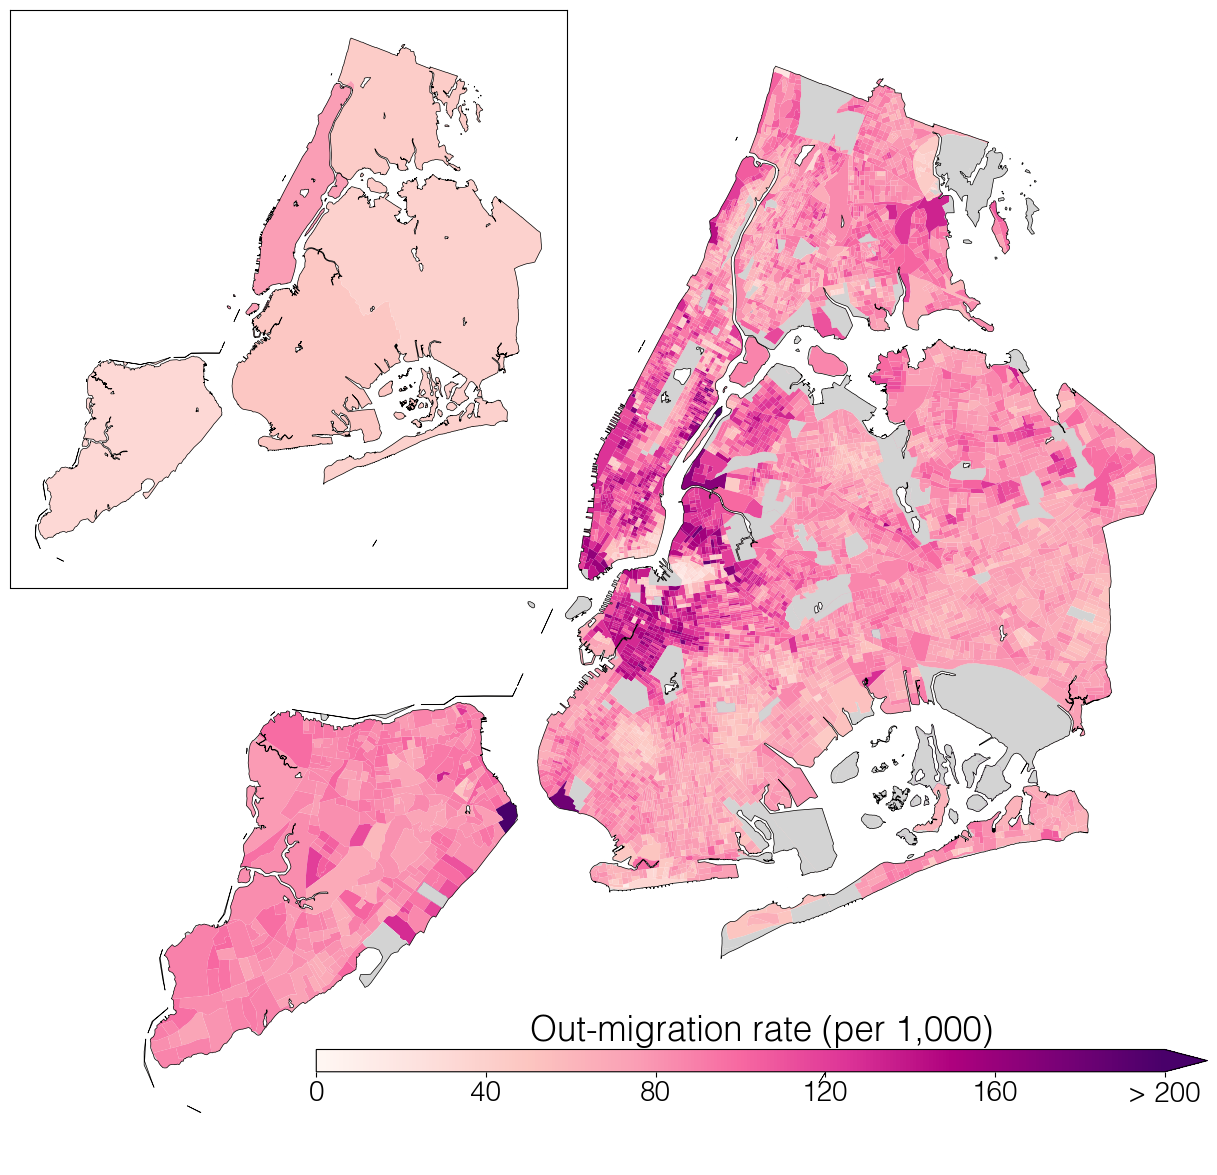

In [15]:
fig, ax = plt.subplots(figsize=(15, 15))

#Plot MIGRATE as main:
ax = viz.map(1_000*flow_avg['out'],
             us_gdf=us_gdf, ax=ax,
             indices=example_cities['CBG']['New York'],
             boundary_gdf=NYC_boundary, vmax=vmax_flows, mask=NYC_mask,
             legend=True, title='Out-migration rate (per 1,000)', colorbar_placement=NYC_colorbar,
             annotate_format=int)

#Plot county level as inset:
ax = ax.inset_axes([-0.075, 0.5, 0.5, 0.5])
ax = viz.map(1_000*ACS_flow_avg['out'],
             us_gdf=county_gdf, legend=False, ax=ax,
             indices=example_cities['county']['New York'],
             boundary_gdf=NYC_boundary, vmax=vmax_flows,
             title=None, axis_off=False)
plt.savefig(f'{plots_dir}flows-NYC-out.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}flows-NYC-out.pdf', dpi=300, bbox_inches='tight')
plt.show()

Income and mobility:

100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  2.70it/s]
/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 10 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 236.45it/s]
/share/pierson/conda_virtualenvs/INFUTOR_env/lib/python3.10/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 25 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


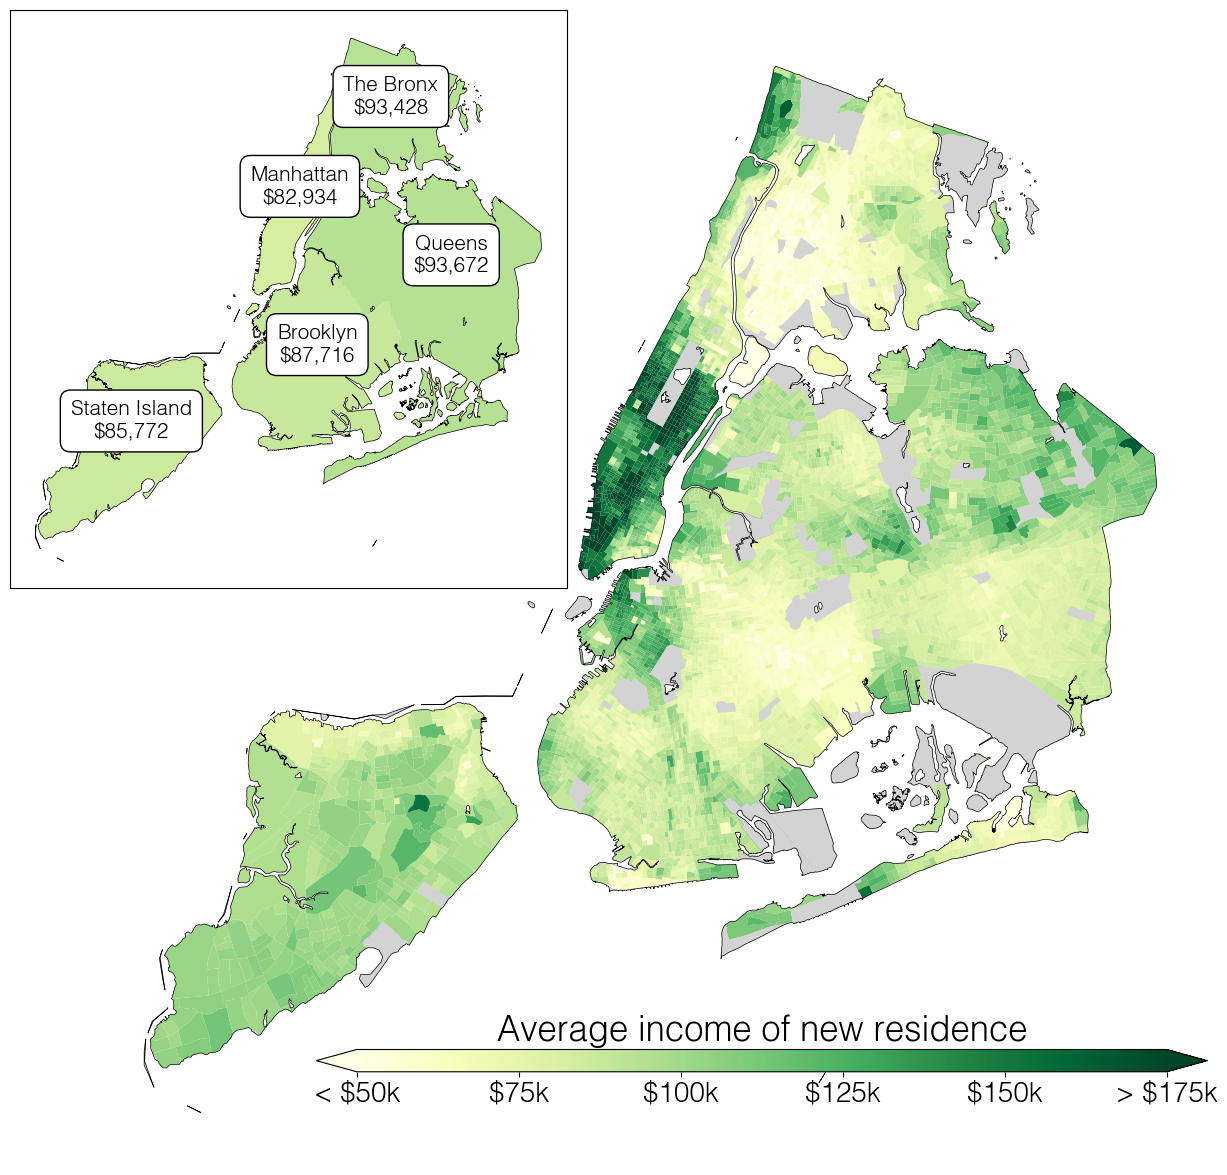

In [18]:
income_vmin = 50_000
income_vmax = 175_000
income_cmap = 'YlGn'
demographic_str = ('Household Income','Mean income')

county_gdf['label'] = county_gdf.NAME.replace({'New York County':'Manhattan',
                                               'Queens County':'Queens',
                                               'Kings County':'Brooklyn',
                                               'Richmond County':'Staten Island',
                                               'Bronx County':'The Bronx'})

#For CBGs:
yearly_average = {}
for migration_year, M in tqdm(M_dict.items()):
    demographics  = ACS_CBG_dem[migration_year-1][demographic_str].values
    yearly_average[migration_year] = eval.average_demographic(M, demographics, movers_only=True, fill_nan=False)
average_destination_income = pd.DataFrame(yearly_average).mean(axis=1)

#Plot:
fig, ax = plt.subplots(figsize=(15, 15))
ax = viz.map(average_destination_income,
             cmap=income_cmap,
             vmin=income_vmin, vmax=income_vmax,
             us_gdf=us_gdf, legend=True, ax=ax, n_ticks=6,
             indices=example_cities['CBG']['New York'],
             title='Average income of new residence',
             annotate=False, annotate_format=lambda x: f'${int(x//1_000):,}k',
             boundary_gdf=NYC_boundary, colorbar_placement=NYC_colorbar, mask=NYC_mask)

#County level:
yearly_average = {}
for migration_year, M in tqdm(F_dict['county'].items()):
    demographics  = ACS_county_dem[migration_year-1][demographic_str].values
    yearly_average[migration_year] = eval.average_demographic(M, demographics, movers_only=True, fill_nan=False)
average_destination_income = pd.DataFrame(yearly_average).mean(axis=1)

#Plot as inset:
ax = ax.inset_axes([-0.075, 0.5, 0.5, 0.5])
ax = viz.map(average_destination_income,
             cmap=income_cmap,
             vmin=income_vmin, vmax=income_vmax,
             us_gdf=county_gdf, legend=False, ax=ax,
             indices=example_cities['county']['New York'],
             title=None, 
             annotate=True, annotate_format=lambda x: f'${int(x):,}',
             include_label_in_annotation=True,
             boundary_gdf=NYC_boundary, axis_off=False)
plt.savefig(f'{plots_dir}flows-NYC-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}flows-NYC-inccome.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4. Stratifying Flows

In [19]:
movers_only = True
all_str = 'Destination of all movers'
groups = {'Race':['Plurality White', 'Plurality Black','Plurality Asian','Plurality Hispanic'],
          'Urbanization':['Urban', 'Rural'],
          'Income':['Bottom income quartile', '2nd income quartile', '3rd income quartile', 'Top income quartile'],
          'Baseline':[all_str]}
stratification_cbar = 'summer_r'
base_rates_by_population = True

### 4a. Out-migration per group:

In [20]:
outmigration_per_group = {}
inmigration_per_group =  {}
population_per_group = {}
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])
    
    #First, collect total out and in migration:
    outmigration = np.array(M.sum(axis=1)).flatten() - M.diagonal()
    inmigration  = np.array(M.sum(axis=0)).flatten() - M.diagonal()
    population = np.array(M.sum(axis=1)).flatten()

    #Select groups:
    outmigration_per_group[migration_year] = {d_group: outmigration[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    inmigration_per_group[migration_year]  = {d_group: inmigration[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    population_per_group[migration_year]   = {d_group: population[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}

outmovers = pd.DataFrame(outmigration_per_group)
inmovers = pd.DataFrame(inmigration_per_group)
population = pd.DataFrame(population_per_group)

#Create a mean and standard deviation:
def clean_group(k):
    if k == 'Race':
        return 'Plurality Race'
    elif k == 'Income':
        return 'Income Quartile'
    else:
        return k

def clean_subgroup(v):
    if 'Plurality' in v:
        return v[10:]
    if 'income' in v:
        return v[:-16]
    else:
        return v

renames = {'Plurality White': 'White',
 'Plurality Black': 'Black',
 'Plurality Asian': 'Asian',
 'Plurality Hispanic': 'Hispanic',
 'Urban': 'Urban',
 'Rural': 'Rural',
 'Bottom income quartile': 'Bottom',
 '2nd income quartile': '2nd',
 '3rd income quartile': '3rd',
 'Top income quartile': 'Top'}

rows = [(group, subgroup) for group, subgroups in groups.items() if group != 'Baseline' for subgroup in subgroups]

est_df = (outmovers.div(population)).mean(axis=1)
est_df = est_df.loc[[subgroup for _, subgroup in rows]]
est_df.index = pd.MultiIndex.from_tuples(rows)
est_df = est_df.rename(index=renames, level=1)
est_df = est_df.rename(index={'Income':'Income Quartile', 'Race':'Plurality Race'}, level=0)

std_df = (outmovers.div(population)).std(axis=1)
std_df = std_df.loc[[subgroup for _, subgroup in rows]]
std_df.index = pd.MultiIndex.from_tuples(rows)
std_df = std_df.rename(index=renames, level=1)
std_df = std_df.rename(index={'Income':'Income Quartile', 'Race':'Plurality Race'}, level=0)

#Get the overall mean and sd:
rates = outmovers.loc[['Urban', 'Rural']].sum(axis=0)/population.loc[['Urban', 'Rural']].sum(axis=0)
estimate, std = rates.mean(), rates.std()

#Display:
outmigration_avg = 1000*(outmovers/population).mean(axis=1)
outmovers_avg = outmovers.mean(axis=1)
population_avg = population.mean(axis=1)
df = pd.concat([outmigration_avg.rename('Out-migration rate (per 1,000)'),
           outmovers_avg.rename('Average out-movers in CBGs'),
           population_avg.rename('Average population in CBGs')],axis=1).astype(int)
display(df)
print(f'Overall out-migration rate: {1_000*estimate:.0f} per 1,000 (sd {1_000*std:.1f})')

100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.50it/s]


Out-migration rate (per 1,000)  \
Plurality Asian                                    124   
Plurality Black                                    128   
Plurality Hispanic                                 118   
Plurality White                                    132   
Rural                                              104   
Urban                                              135   
2nd income quartile                                130   
3rd income quartile                                131   
Bottom income quartile                             130   
Top income quartile                                128   

                        Average out-movers in CBGs  Average population in CBGs  
Plurality Asian                             889755                     7170171  
Plurality Black                            3823677                    29748068  
Plurality Hispanic                         5289710                    44773071  
Plurality White                           31425400                   236642647  
Rural                                      5947401                    57097636  
Urban                                     35481142                   261236322  
2nd income quartile                        9944217                    76203021  
3rd income quartile                       11011339                    83752130  
Bottom income quartile                     8621155                    66144335  
Top income quartile                       11851831                    92234472

Overall out-migration rate: 130 per 1,000 (sd 8.8)


### 4b. Distance of moves

First, raw distance:

100%|█████████████████████████████████████████████| 9/9 [09:43<00:00, 64.78s/it]


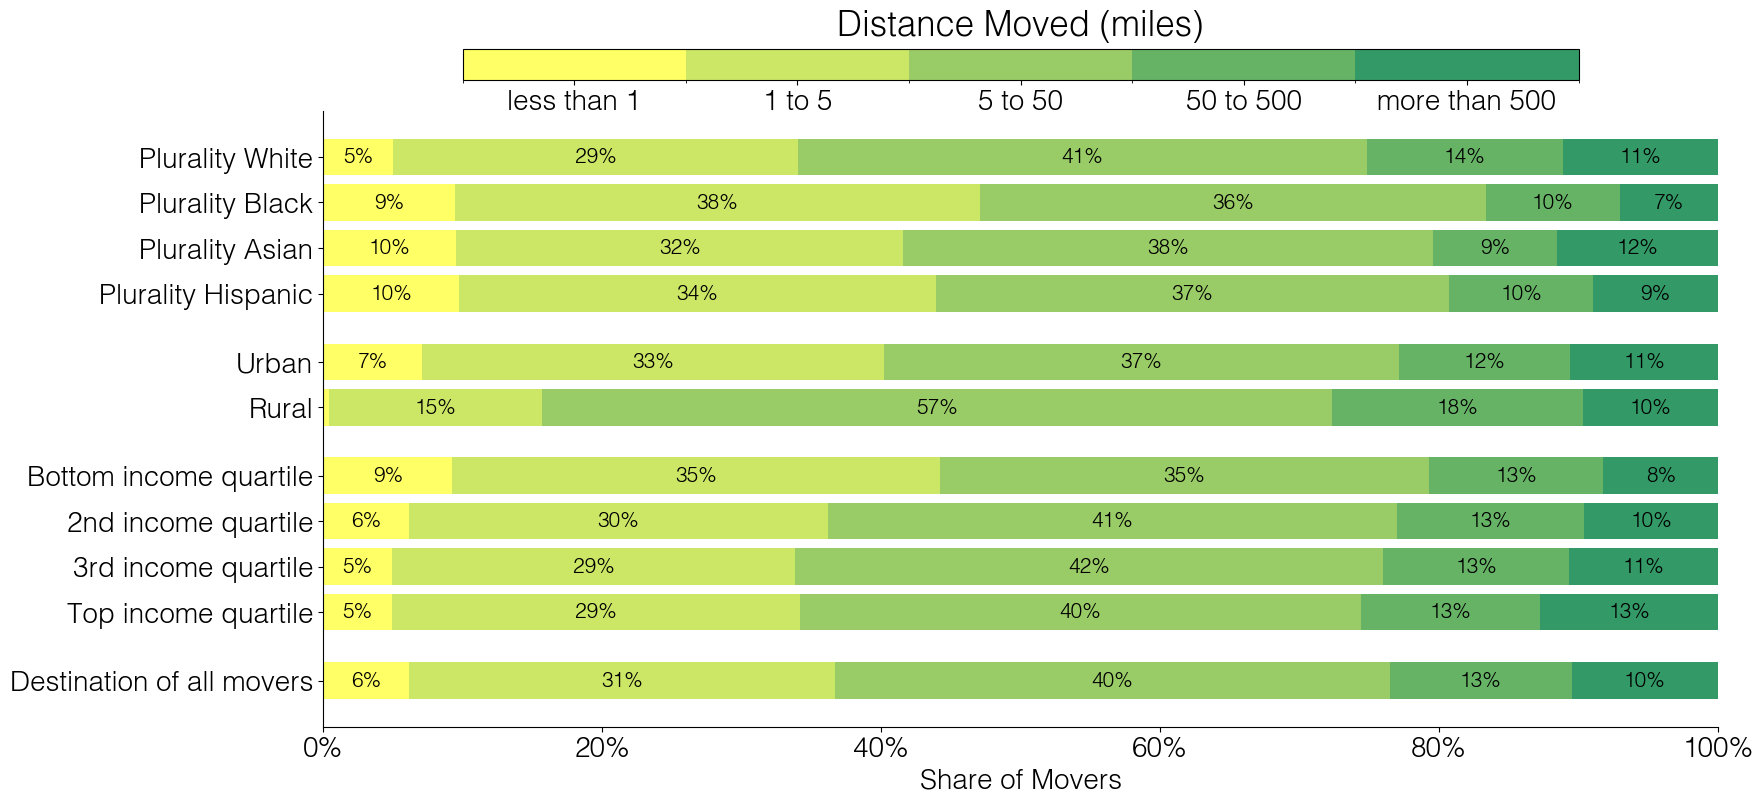

In [21]:
#First compute centroids (this needs to be done on a projected, area-preserving CRS) in lat-long:
us_gdf = gpd.read_file(f'{vars._census_spatial_dir}processed/BLOCK_GROUP.gpkg')
centroids_projected = us_gdf.to_crs(vars._area_crs).geometry.centroid
centroids_latlon_geo = gpd.GeoSeries(centroids_projected, crs=vars._area_crs).to_crs('EPSG:4326')
centroids_latlon = np.array([[pt.y, pt.x] for pt in centroids_latlon_geo])

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_moves_by_distance_per_group = {}
yearly_total_per_group =  {}
yearly_average_distance = {}
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])

    #Collect geographic groups:
    if movers_only: M -= ss.diags(M.diagonal())
    CBG_moves_by_distance, distance_avg = eval.count_moves_by_haversine_distance(M, centroids_latlon,
                                                                                 distance_bins=[1, 5, 50, 500], distance_unit='mile', include_distance_unit=False,
                                                                                 return_weighted_average=True)

    #Aggregate rows by the origin demographic group:
    CBG_moves_by_distance_per_group = {d_group: CBG_moves_by_distance.iloc[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    CBG_moves_by_distance_per_group[all_str] = CBG_moves_by_distance.sum()

    #Collect the yearly dataframe:
    yearly_moves_by_distance_per_group[migration_year] = pd.DataFrame(CBG_moves_by_distance_per_group).T

    #We will also want to keep track of the total number of movers or population (for normalization):
    total_per_CBG = np.array(M.sum(axis=1)).flatten()
    #if movers_only: total_per_CBG -= M.diagonal()
    total_per_group = {d_group: total_per_CBG[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}|{all_str:total_per_CBG.sum()}
    yearly_total_per_group[migration_year] = pd.Series(total_per_group)

    #And the average distance per group:
    CBGs_with_movers = total_per_CBG > 0
    average_distance_per_group = {d_group: np.average(distance_avg[d_group_indices][CBGs_with_movers[d_group_indices]],
                                                      weights=total_per_CBG[d_group_indices][CBGs_with_movers[d_group_indices]])
                                  for d_group, d_group_indices in CBG_demographic_groups.items()}
    average_distance_per_group[all_str] = np.average(distance_avg[CBGs_with_movers], weights=total_per_CBG[CBGs_with_movers])
    yearly_average_distance[migration_year] = pd.Series(average_distance_per_group)

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_move_rates_by_distance_per_group = {year: yearly_counts.div(yearly_total_per_group[year], axis=0) for year, yearly_counts in yearly_moves_by_distance_per_group.items()}
aggregated_rates_by_distance_per_group = sum(yearly_move_rates_by_distance_per_group.values())/len(yearly_move_rates_by_distance_per_group)
if movers_only: aggregated_rates_by_distance_per_group = aggregated_rates_by_distance_per_group.drop(['Not moving'], axis=1, errors='ignore')

#Plot:
_ = viz.plot_stacked_bars(aggregated_rates_by_distance_per_group, groups, colors=stratification_cbar, title='Distance Moved (miles)', discretized_colorbar_legend=True, distance_unit_label=None, colorbar_top=True)
plt.savefig(f'{plots_dir}summaries-distance.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-distance.pdf', dpi=300, bbox_inches='tight')
plt.show()

Time series:

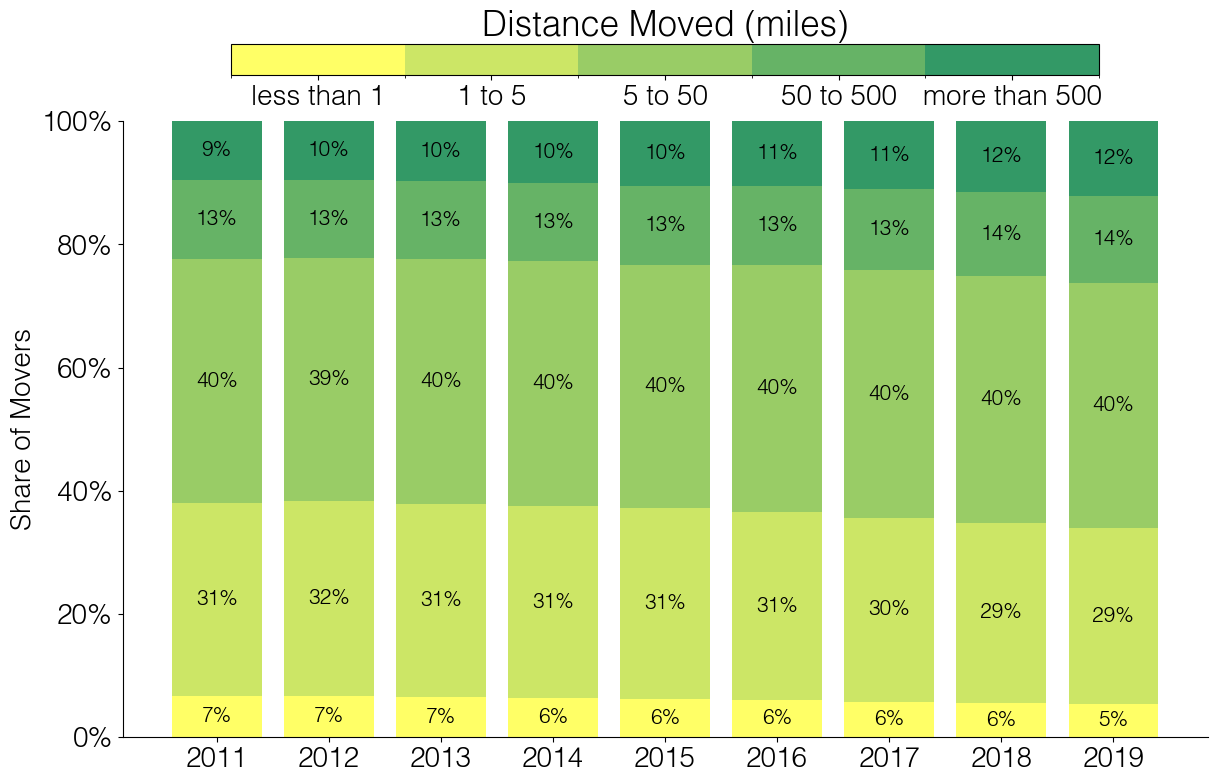

In [22]:
all_movers_over_time = pd.concat([df.loc[all_str].rename(year) for year, df in yearly_move_rates_by_distance_per_group.items()],axis=1).T
avg_distance_over_time = [df.loc[all_str] for df in yearly_average_distance.values()]
_ = viz.plot_stacked_bars_vertical(all_movers_over_time, colors=stratification_cbar, title='Distance Moved (miles)', discretized_colorbar_legend=True, distance_unit_label=None, colorbar_top=True,
                                   plot_yearly_value=False, yearly_values=avg_distance_over_time, yearly_range=(150, 200))
plt.savefig(f'{plots_dir}summaries-distance-yearly.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-distance-yearly.pdf', dpi=300, bbox_inches='tight')
plt.show()

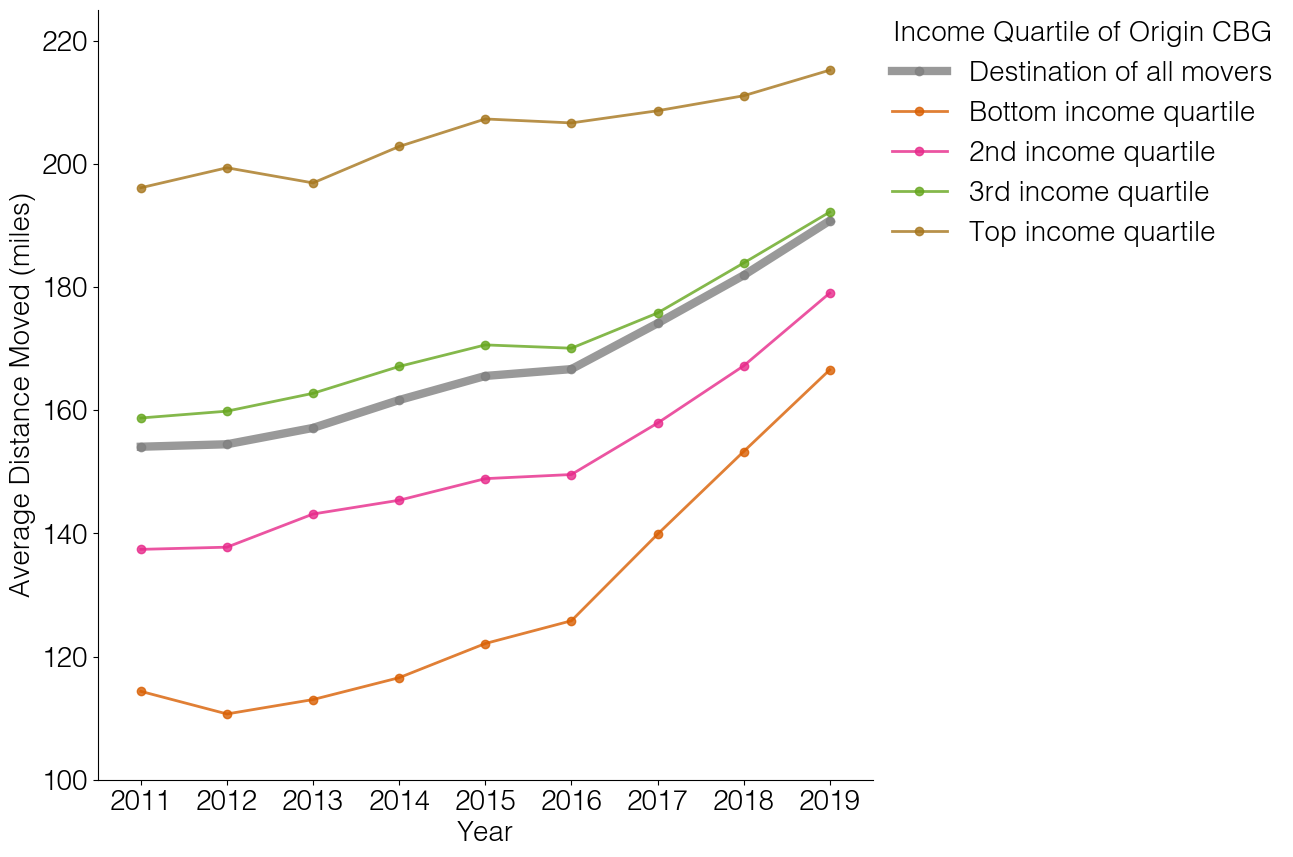

In [23]:
avg_distance_over_time = pd.concat([df.loc[[all_str, 'Bottom income quartile', '2nd income quartile', '3rd income quartile', 'Top income quartile']].rename(year) for year,df in yearly_average_distance.items()],axis=1)
_ = viz.plot_mobility_trends(avg_distance_over_time, baseline=all_str, yrange=(100,225), legend_loc='outside top right')
plt.savefig(f'{plots_dir}summaries-distance-by-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-distance-by-income.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.show()

Now geography:

100%|█████████████████████████████████████████████| 9/9 [06:13<00:00, 41.51s/it]


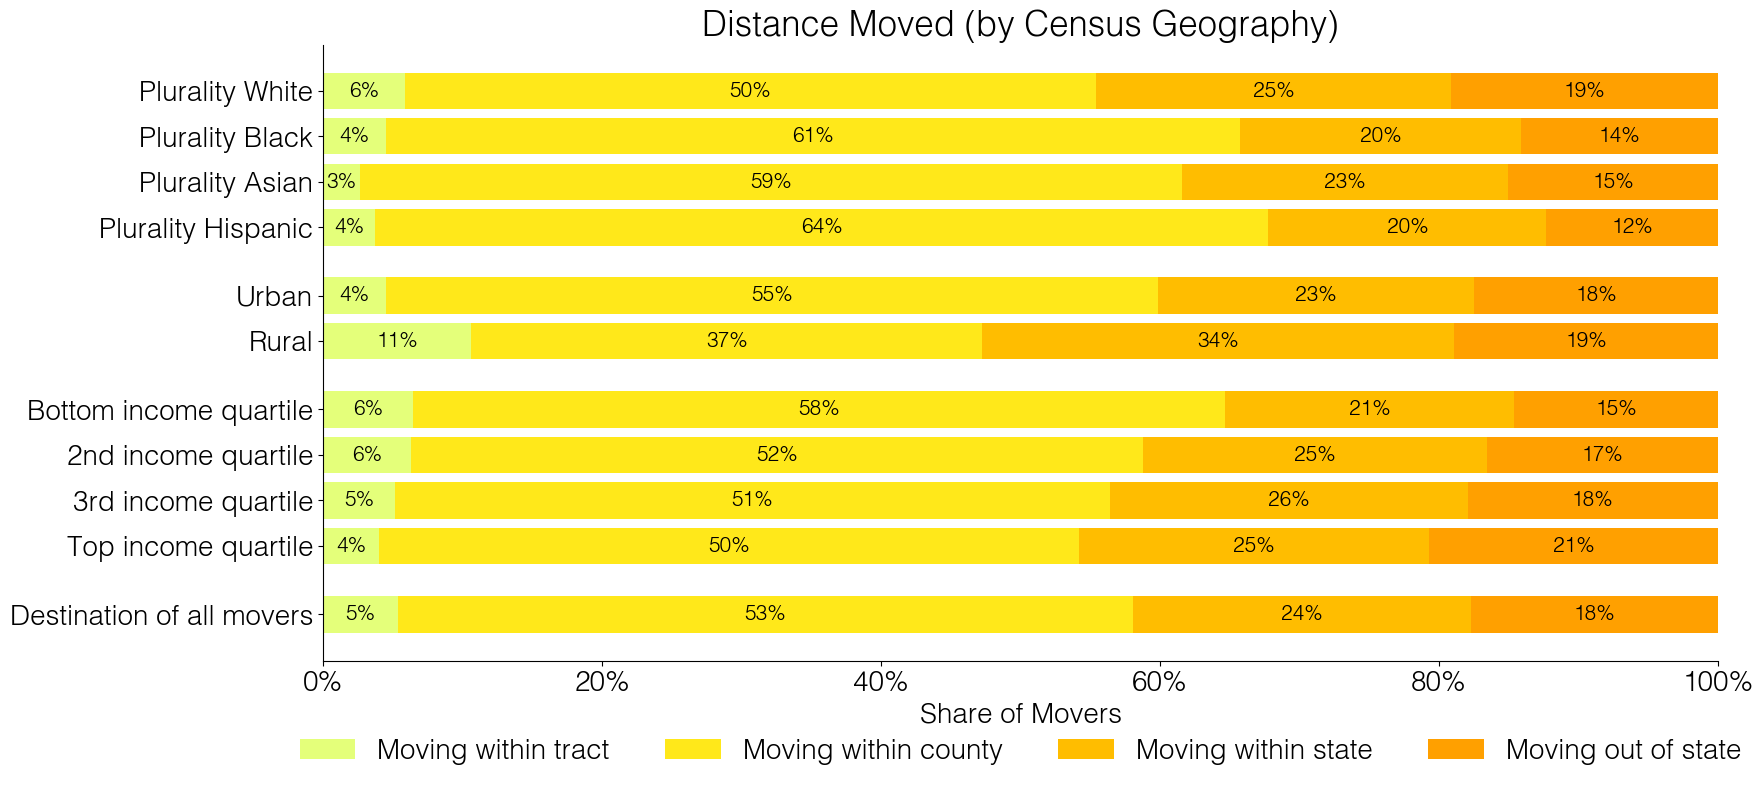

In [24]:
#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_moves_by_distance_per_group = {}
yearly_total_per_group =  {}
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])

    #Collect geographic groups:
    CBG_moves_by_distance = eval.count_moves_by_distance(M, C_dict)

    #Aggregate rows by the origin demographic group:
    CBG_moves_by_distance_per_group = {d_group: CBG_moves_by_distance.iloc[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    CBG_moves_by_distance_per_group[all_str] = CBG_moves_by_distance.sum()

    #Collect the yearly dataframe:
    yearly_moves_by_distance_per_group[migration_year] = pd.DataFrame(CBG_moves_by_distance_per_group).T

    #We will also want to keep track of the total number of movers or population (for normalization):
    total_per_CBG = np.array(M.sum(axis=1)).flatten()
    if movers_only: total_per_CBG -= M.diagonal()
    total_per_group = {d_group: total_per_CBG[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}|{all_str:total_per_CBG.sum()}
    yearly_total_per_group[migration_year] = pd.Series(total_per_group)

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_move_rates_by_distance_per_group = {year: yearly_counts.div(yearly_total_per_group[year], axis=0) for year, yearly_counts in yearly_moves_by_distance_per_group.items()}
aggregated_rates_by_distance_per_group = sum(yearly_move_rates_by_distance_per_group.values())/len(yearly_move_rates_by_distance_per_group)
if movers_only: aggregated_rates_by_distance_per_group = aggregated_rates_by_distance_per_group.drop('Not moving', axis=1)

#Plot:
_ = viz.plot_stacked_bars(aggregated_rates_by_distance_per_group, groups, colors='Wistia', title='Distance Moved (by Census Geography)')
plt.savefig(f'{plots_dir}summaries-distance-geography.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-distance-geography.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 4c. OD matrix by demographics

Where they moved:

100%|█████████████████████████████████████████████| 9/9 [00:32<00:00,  3.62s/it]


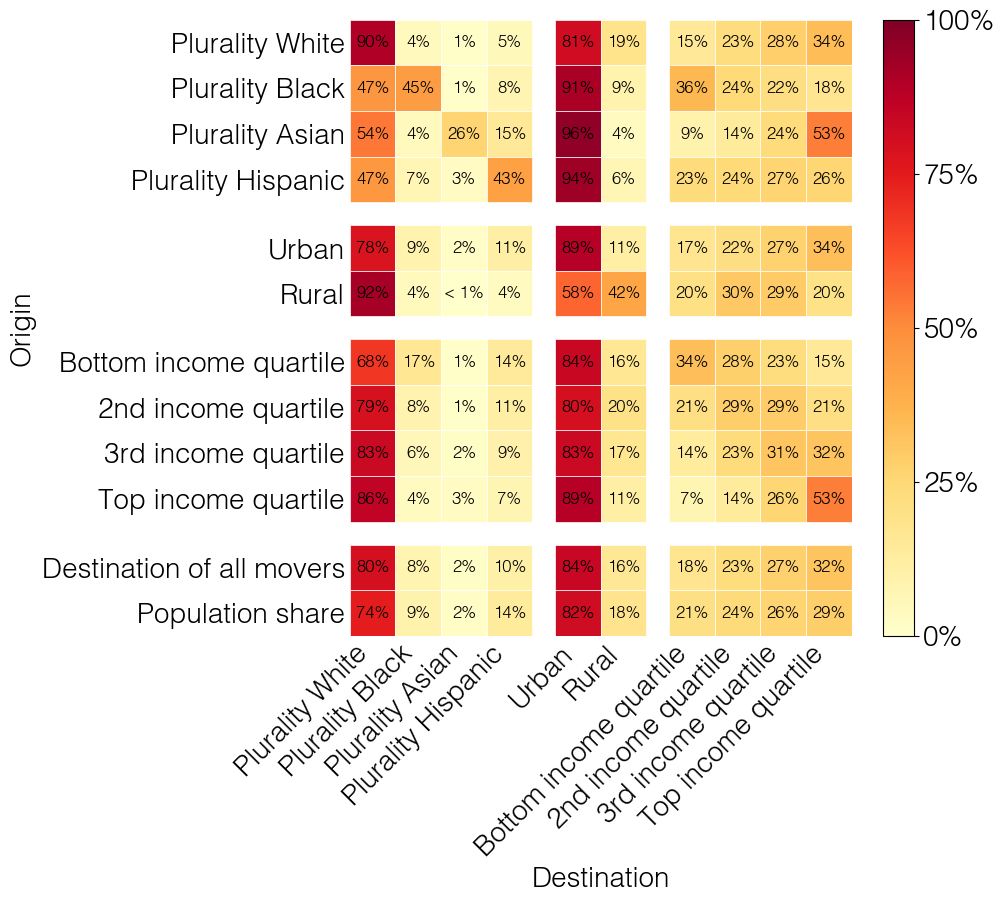

In [25]:
#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_moves_by_destination_per_group = {}
yearly_total_per_group = {}
yearly_base_rates = {}
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])
    yearly_base_rates[migration_year] = eval.get_base_rates(CBG_demographic_groups, N=M.shape[0],
                                                            weights=demographics_raw['Total']['Population'].fillna(0).values if base_rates_by_population else None)

    #Aggregate moves by destination group:
    CBG_moves_by_destination = eval.count_moves_by_group(M, CBG_demographic_groups, movers_only=True)

    #Aggregate rows by the origin demographic group:
    CBG_moves_by_destination_per_group = {d_group: CBG_moves_by_destination.iloc[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    CBG_moves_by_destination_per_group[all_str] = CBG_moves_by_destination.sum()

    #Collect the yearly dataframe:
    yearly_moves_by_destination_per_group[migration_year] = pd.DataFrame(CBG_moves_by_destination_per_group).T

    #We will also want to keep track of the total number of movers or population (for normalization):
    total_per_CBG = np.array(M.sum(axis=1)).flatten()
    if movers_only: total_per_CBG -= M.diagonal()
    total_per_group = {d_group: total_per_CBG[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}|{all_str:total_per_CBG.sum()}
    yearly_total_per_group[migration_year] = pd.Series(total_per_group)

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_move_rates_by_destination_per_group = {year: yearly_counts.div(yearly_total_per_group[year], axis=0) for year, yearly_counts in yearly_moves_by_destination_per_group.items()}
aggregated_rates_by_destination_per_group = sum(yearly_move_rates_by_destination_per_group.values())/len(yearly_move_rates_by_destination_per_group)
base_rates = (sum(yearly_base_rates.values())/len(yearly_base_rates)).to_dict()

_ = viz.plot_mover_heatmap(aggregated_rates_by_destination_per_group, groups, random_baseline=base_rates, all_str=all_str, cbar_label=None)
plt.savefig(f'{plots_dir}summaries-heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-heatmap.pdf', dpi=300, bbox_inches='tight')
plt.show()

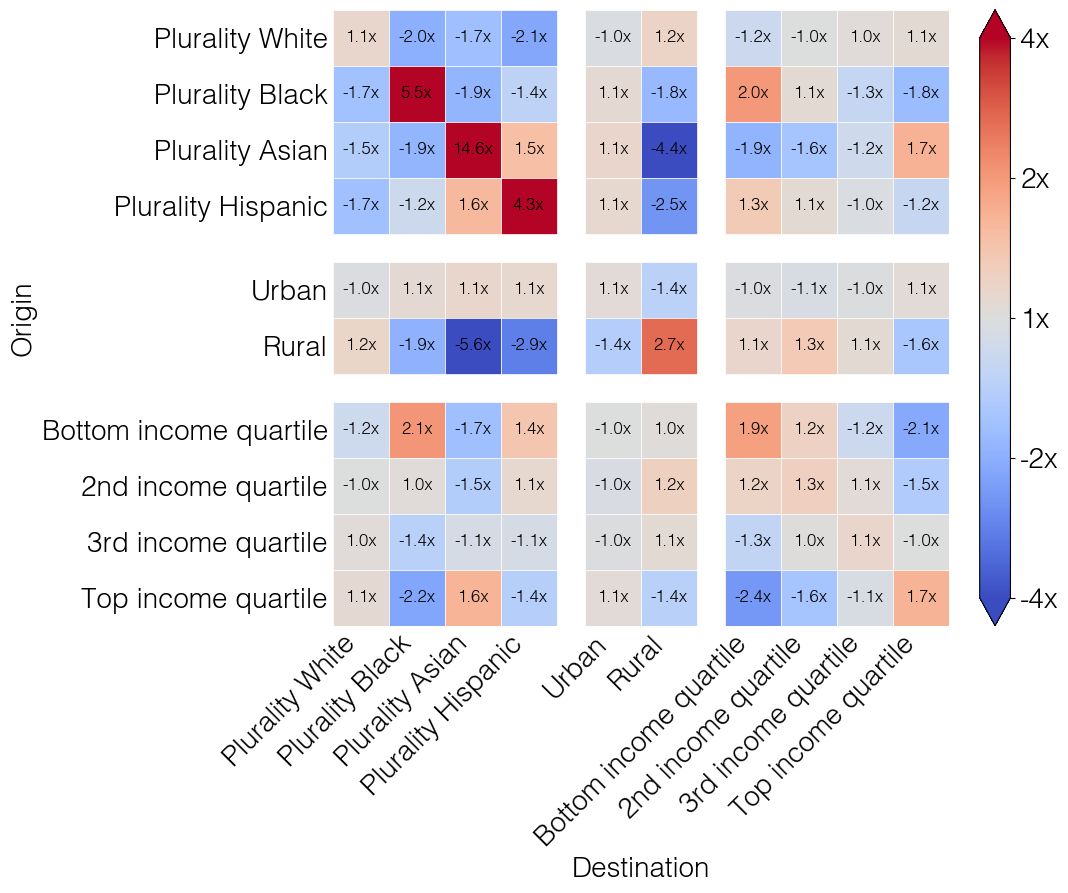

In [26]:
_ = viz.plot_mover_heatmap(aggregated_rates_by_destination_per_group, groups, all_str=all_str,
                           relative_to_baseline=True, cmap='coolwarm', cbar_label=None)
plt.savefig(f'{plots_dir}summaries-heatmap-relative.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-heatmap-relative.pdf', dpi=300, bbox_inches='tight')
plt.show()

And the share of folks who moved to top and bottom income CBGs over time:

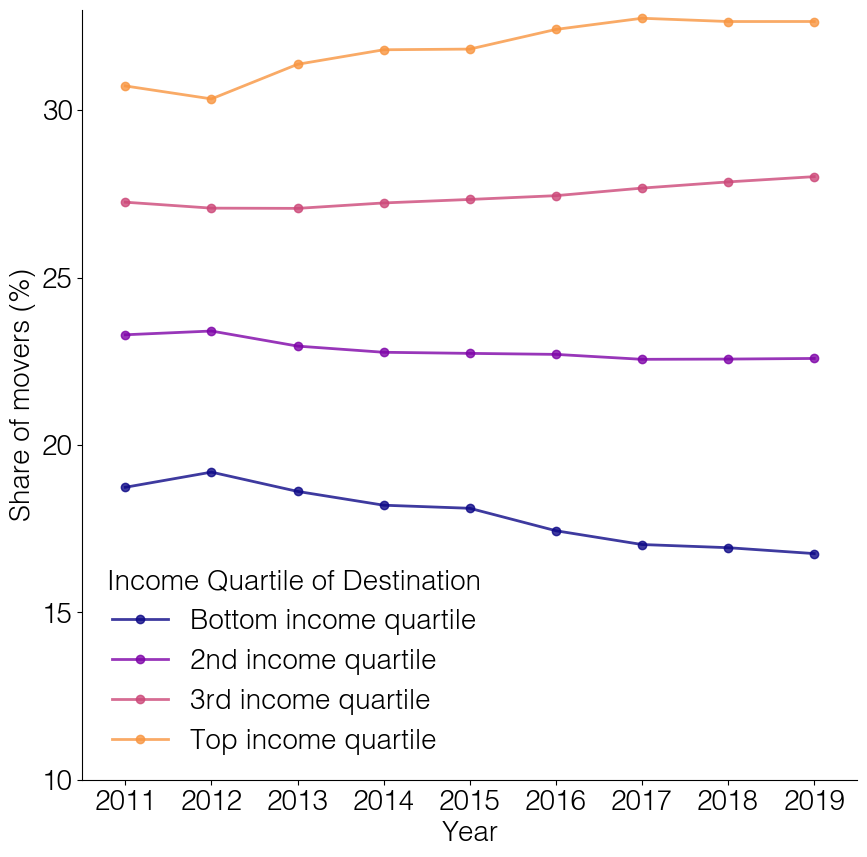

2011       2012       2013       2014       2015  \
Bottom income quartile  18.735094  19.187989  18.611708  18.199691  18.107879   
2nd income quartile     23.290686  23.402746  22.952222  22.767768  22.735045   
3rd income quartile     27.250958  27.073135  27.066113  27.228471  27.332876   
Top income quartile     30.723262  30.336130  31.369957  31.804070  31.824200   

                             2016       2017       2018       2019  
Bottom income quartile  17.437374  17.025483  16.930933  16.754556  
2nd income quartile     22.705038  22.557447  22.565025  22.583191  
3rd income quartile     27.445807  27.671810  27.856748  28.014125  
Top income quartile     32.411781  32.745259  32.647294  32.648127

In [27]:
income_moves = {}
for destination in ['Bottom income quartile', '2nd income quartile', '3rd income quartile', 'Top income quartile']:
    income_moves[destination] = [df.loc[all_str, destination] for df in yearly_move_rates_by_destination_per_group.values()]

income_moves_over_time = 100*pd.DataFrame(income_moves, index=yearly_move_rates_by_destination_per_group.keys()).T
_ = viz.plot_mobility_trends(income_moves_over_time, legend_loc='lower left', yrange=(10, 33), legend_title='Income Quartile of Destination', ylabel='Share of movers (%)', colors='plasma')
plt.savefig(f'{plots_dir}summaries-by-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-by-income.pdf', dpi=300, bbox_inches='tight')
plt.show()
display(income_moves_over_time)

Out-of-county moves only

100%|█████████████████████████████████████████████| 9/9 [00:52<00:00,  5.79s/it]


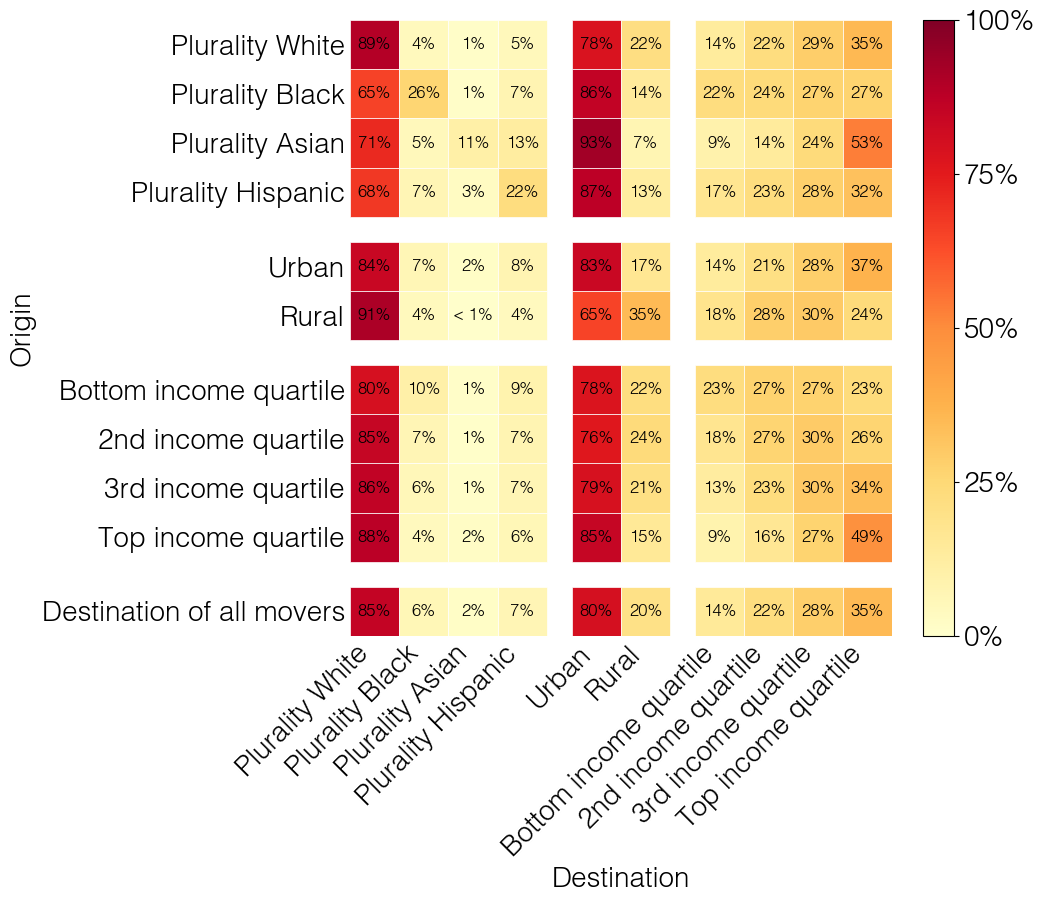

In [28]:
within_geography = 'county'

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_moves_by_destination_per_group = {}
yearly_total_per_group = {}
yearly_base_rates = {}
for migration_year, M in tqdm(M_dict.items()):
    
    #Collect demographic groups:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])
    yearly_base_rates[migration_year] = eval.get_base_rates(CBG_demographic_groups, N=M.shape[0],
                                                            weights=demographics_raw['Total']['Population'].fillna(0).values if base_rates_by_population else None)

    #Filter for out-of-geography moves:
    C = C_dict[('blockgroup', within_geography)]
    M_within = M.multiply(C @ C.T)
    M = M - M_within


    #Aggregate moves by destination group:
    CBG_moves_by_destination = eval.count_moves_by_group(M, CBG_demographic_groups, movers_only=True)

    #Aggregate rows by the origin demographic group:
    CBG_moves_by_destination_per_group = {d_group: CBG_moves_by_destination.iloc[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}
    CBG_moves_by_destination_per_group[all_str] = CBG_moves_by_destination.sum()

    #Collect the yearly dataframe:
    yearly_moves_by_destination_per_group[migration_year] = pd.DataFrame(CBG_moves_by_destination_per_group).T

    #We will also want to keep track of the total number of movers or population (for normalization):
    total_per_CBG = np.array(M.sum(axis=1)).flatten()
    if movers_only: total_per_CBG -= M.diagonal()
    total_per_group = {d_group: total_per_CBG[d_group_indices].sum() for d_group, d_group_indices in CBG_demographic_groups.items()}|{all_str:total_per_CBG.sum()}
    yearly_total_per_group[migration_year] = pd.Series(total_per_group)

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_move_rates_by_destination_per_group = {year: yearly_counts.div(yearly_total_per_group[year], axis=0) for year, yearly_counts in yearly_moves_by_destination_per_group.items()}
aggregated_rates_by_destination_per_group = sum(yearly_move_rates_by_destination_per_group.values())/len(yearly_move_rates_by_destination_per_group)
base_rates = (sum(yearly_base_rates.values())/len(yearly_base_rates)).to_dict()

_ = viz.plot_mover_heatmap(aggregated_rates_by_destination_per_group, groups, random_baseline=False, all_str=all_str, cbar_label=None)
plt.savefig(f'{plots_dir}summaries-heatmap-outof{within_geography}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-heatmap-outof{within_geography}.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 4d. Income homophilly

100%|█████████████████████████████████████████████| 9/9 [00:44<00:00,  4.89s/it]


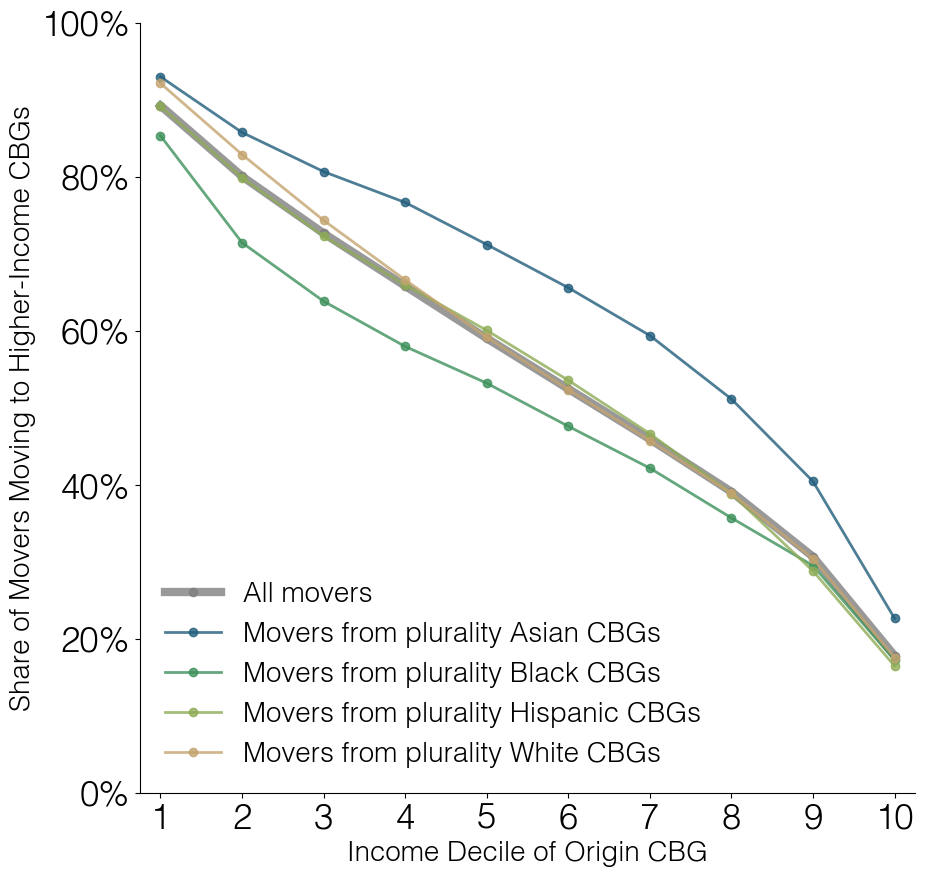

Race
All movers                             53.071588
Movers from plurality Asian CBGs       50.519224
Movers from plurality Black CBGs       64.601766
Movers from plurality Hispanic CBGs    63.634768
Movers from plurality White CBGs       49.988909
dtype: float64

In [29]:
x_axis_n = 10

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_upward_moves, yearly_upward_moves_per_group = {}, {}
for migration_year, M in tqdm(M_dict.items()):
        
    #Collect demographics and upward-income moves:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    median_income = demographics_raw['Household Income']['Median income'].values
    upward_moves = eval.count_moves_upwards(M, median_income)

    #Collect total:
    total = np.array(M.sum(axis=1)).flatten()
    if movers_only: total -= M.diagonal()
        
    #We will need to ignore CBGs with zero income
    mask = median_income > 0

    #Get income deciles and race (save this CBG dataframe for mapping):
    CBG_df = pd.DataFrame({'Race': 'Movers from plurality ' + demographics_raw['Race'].idxmax(axis=1).values[mask] + ' CBGs',
                           'Income': pd.qcut(median_income[mask], q=x_axis_n, labels=range(1, x_axis_n+1)),
                           'Upward Moves': upward_moves[mask], 'Total': total[mask]})
    
    #Aggregate:
    upward_moves_per_group = CBG_df.groupby(['Race', 'Income'], observed=True).sum()
    upward_movers_total = CBG_df.groupby('Income', observed=True).sum()
    upward_movers_total['Race'] = 'All movers'
    upward_movers_total = upward_movers_total.set_index('Race', append=True).reorder_levels(['Race', 'Income'])

    #Save:
    yearly_upward_moves_per_group[migration_year] = pd.concat([upward_moves_per_group, upward_movers_total]).sort_index()

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_upward_move_rates_per_group = {year: (yearly_counts['Upward Moves']/yearly_counts['Total']).unstack(level=1) for year, yearly_counts in yearly_upward_moves_per_group.items()}
aggregated_rates_per_group = (sum(yearly_upward_move_rates_per_group.values())/len(yearly_upward_move_rates_per_group)).to_dict(orient='index')

#Plot:
_ = viz.plot_upwards_mobility(aggregated_rates_per_group, number_of_quantiles=x_axis_n,colors='gist_earth',
                              legend_title=None, title=None, fontsize=25, plot_random_baseline=False)
plt.savefig(f'{plots_dir}summaries-homophily-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-homophily-income.pdf', dpi=300, bbox_inches='tight')
plt.show()

#For the full report:
agg = []
for df in yearly_upward_moves_per_group.values():
    grouped = df.groupby('Race').sum()
    by_race = grouped['Upward Moves']/grouped['Total']
    agg.append(by_race)
display(100*sum(agg)/len(agg))

Share going to top income CBG?

100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.40s/it]


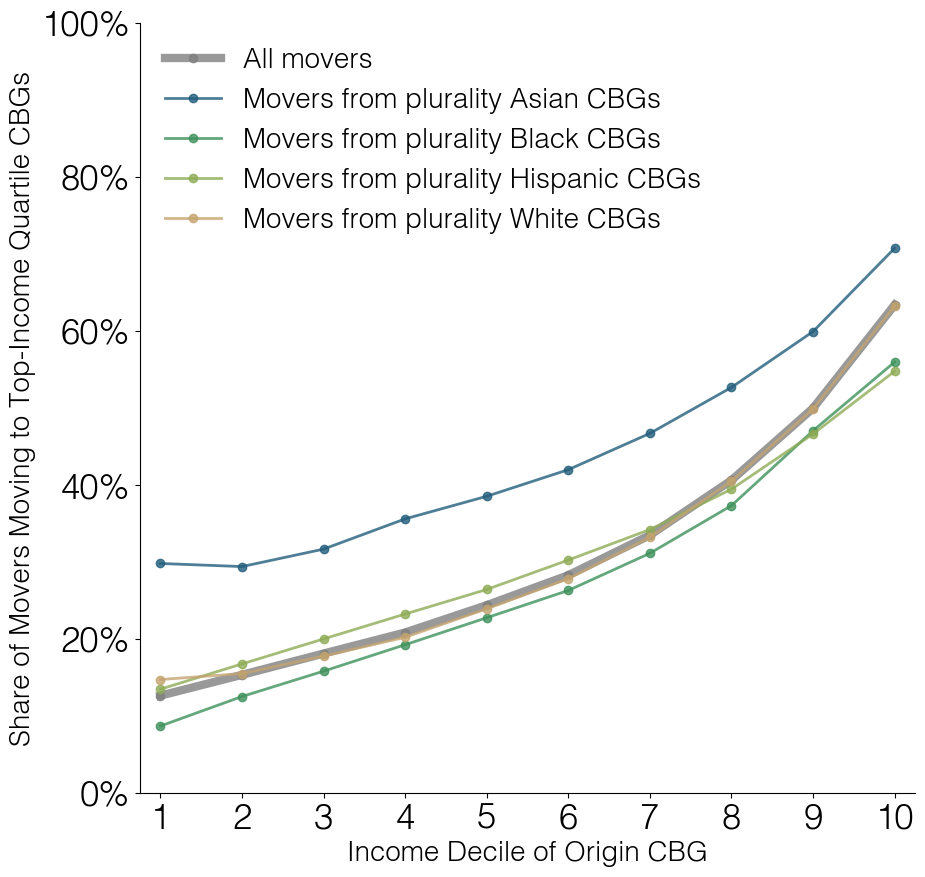

In [30]:
x_axis_n = 10

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_upward_moves, yearly_upward_moves_per_group = {}, {}
for migration_year, M in tqdm(M_dict.items()):
        
    #Collect demographics and upward-income moves:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])
    upward_moves = eval.count_moves_within_CBGs(M, CBG_demographic_groups['Top income quartile'], movers_only=movers_only).values.flatten()

    #Collect total:
    total = np.array(M.sum(axis=1)).flatten()
    if movers_only: total -= M.diagonal()
        
    #We will need to ignore CBGs with zero income
    mask = median_income > 0

    #Get income deciles and race (save this CBG dataframe for mapping):
    CBG_df = pd.DataFrame({'Race': 'Movers from plurality ' + demographics_raw['Race'].idxmax(axis=1).values[mask] + ' CBGs',
                           'Income': pd.qcut(median_income[mask], q=x_axis_n, labels=range(1, x_axis_n+1)),
                           'Moves to Top Income CBG': upward_moves[mask], 'Total': total[mask]})
    
    #Aggregate:
    upward_moves_per_group = CBG_df.groupby(['Race', 'Income'], observed=True).sum()
    upward_movers_total = CBG_df.groupby('Income', observed=True).sum()
    upward_movers_total['Race'] = 'All movers'
    upward_movers_total = upward_movers_total.set_index('Race', append=True).reorder_levels(['Race', 'Income'])

    #Save:
    yearly_upward_moves_per_group[migration_year] = pd.concat([upward_moves_per_group, upward_movers_total]).sort_index()

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_upward_move_rates_per_group = {year: (yearly_counts['Moves to Top Income CBG']/yearly_counts['Total']).unstack(level=1) for year, yearly_counts in yearly_upward_moves_per_group.items()}
aggregated_rates_per_group = (sum(yearly_upward_move_rates_per_group.values())/len(yearly_upward_move_rates_per_group)).to_dict(orient='index')

#Plot:
_ = viz.plot_upwards_mobility(aggregated_rates_per_group, number_of_quantiles=x_axis_n,colors='gist_earth',
                              legend_title=None, title=None, fontsize=25, plot_random_baseline=False, legend_loc='upper left',
                              ylabel='Share of Movers Moving to Top-Income Quartile CBGs')
plt.savefig(f'{plots_dir}summaries-top-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-top-income.pdf', dpi=300, bbox_inches='tight')
plt.show()

100%|█████████████████████████████████████████████| 9/9 [00:30<00:00,  3.41s/it]


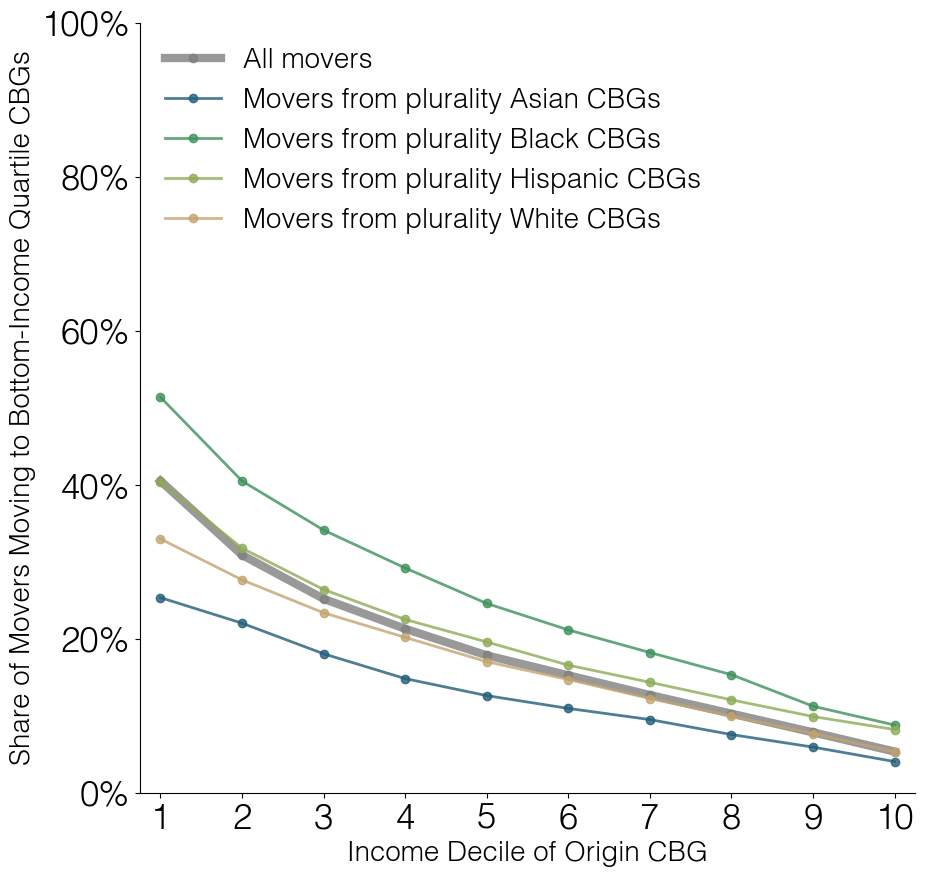

In [31]:
x_axis_n = 10

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_upward_moves, yearly_upward_moves_per_group = {}, {}
for migration_year, M in tqdm(M_dict.items()):
        
    #Collect demographics and upward-income moves:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    CBG_demographic_groups = eval.get_demographic_groups(demographics_raw, income_q=len(groups['Income']), income_labels=groups['Income'])
    upward_moves = eval.count_moves_within_CBGs(M, CBG_demographic_groups['Bottom income quartile'], movers_only=movers_only).values.flatten()

    #Collect total:
    total = np.array(M.sum(axis=1)).flatten()
    if movers_only: total -= M.diagonal()
        
    #We will need to ignore CBGs with zero income
    mask = median_income > 0

    #Get income deciles and race (save this CBG dataframe for mapping):
    CBG_df = pd.DataFrame({'Race': 'Movers from plurality ' + demographics_raw['Race'].idxmax(axis=1).values[mask] + ' CBGs',
                           'Income': pd.qcut(median_income[mask], q=x_axis_n, labels=range(1, x_axis_n+1)),
                           'Moves to Bottom Income CBG': upward_moves[mask], 'Total': total[mask]})
    
    #Aggregate:
    upward_moves_per_group = CBG_df.groupby(['Race', 'Income'], observed=True).sum()
    upward_movers_total = CBG_df.groupby('Income', observed=True).sum()
    upward_movers_total['Race'] = 'All movers'
    upward_movers_total = upward_movers_total.set_index('Race', append=True).reorder_levels(['Race', 'Income'])

    #Save:
    yearly_upward_moves_per_group[migration_year] = pd.concat([upward_moves_per_group, upward_movers_total]).sort_index()

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_upward_move_rates_per_group = {year: (yearly_counts['Moves to Bottom Income CBG']/yearly_counts['Total']).unstack(level=1) for year, yearly_counts in yearly_upward_moves_per_group.items()}
aggregated_rates_per_group = (sum(yearly_upward_move_rates_per_group.values())/len(yearly_upward_move_rates_per_group)).to_dict(orient='index')

#Plot:
_ = viz.plot_upwards_mobility(aggregated_rates_per_group, number_of_quantiles=x_axis_n,colors='gist_earth',
                              legend_title=None, title=None, fontsize=25, plot_random_baseline=False, legend_loc='upper left',
                              ylabel='Share of Movers Moving to Bottom-Income Quartile CBGs')
plt.savefig(f'{plots_dir}summaries-bottom-income.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-bottom-income.pdf', dpi=300, bbox_inches='tight')
plt.show()

Percentile:

100%|█████████████████████████████████████████████| 9/9 [00:25<00:00,  2.88s/it]


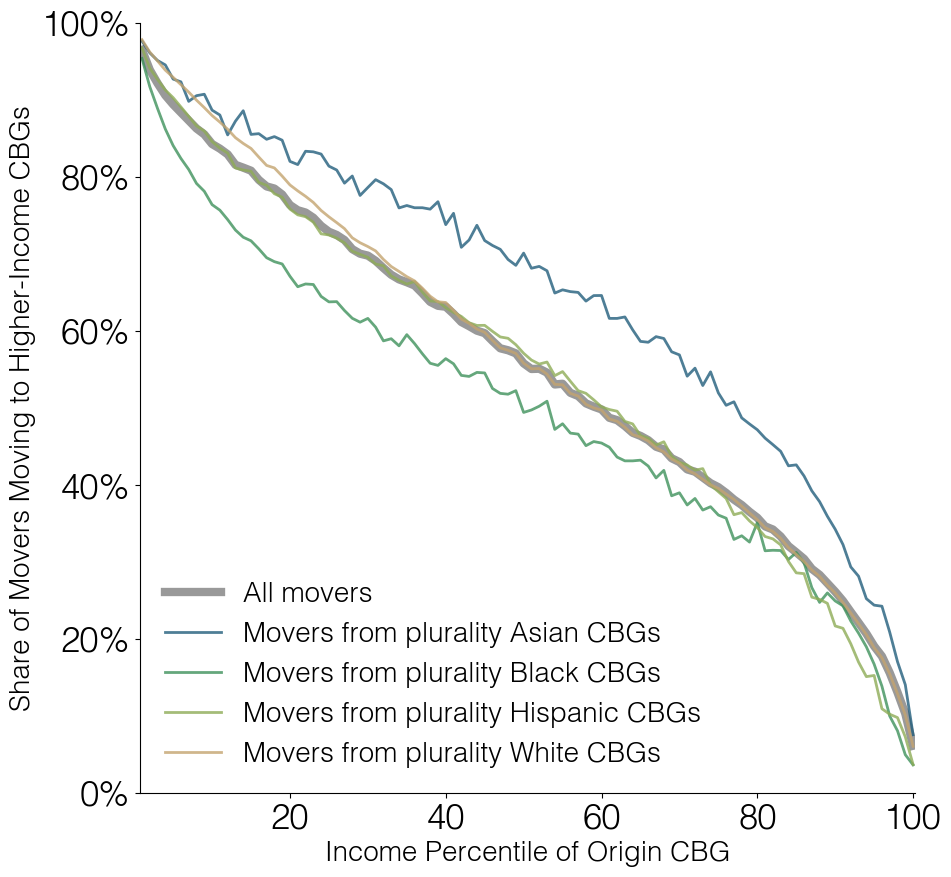

In [32]:
x_axis_n = 100

#Let's collect the information per year first (so that we can consider different aggregation methods):
yearly_upward_moves, yearly_upward_moves_per_group = {}, {}
for migration_year, M in tqdm(M_dict.items()):
        
    #Collect demographics and upward-income moves:
    demographics_raw = ACS_CBG_dem[migration_year-1]
    median_income = demographics_raw['Household Income']['Median income'].values
    upward_moves = eval.count_moves_upwards(M, median_income)

    #Collect total:
    total = np.array(M.sum(axis=1)).flatten()
    if movers_only: total -= M.diagonal()

    #We will need to ignore CBGs with zero income
    mask = median_income > 0

    #Get income percentiles and race (save this CBG dataframe for mapping):
    CBG_df = pd.DataFrame({'Race': 'Movers from plurality ' + demographics_raw['Race'].idxmax(axis=1).values[mask] + ' CBGs',
                           'Income': pd.qcut(median_income[mask], q=x_axis_n, labels=range(1, x_axis_n+1)),
                           'Upward Moves': upward_moves[mask], 'Total': total[mask]})
    
    #Aggregate:
    upward_moves_per_group = CBG_df.groupby(['Race', 'Income'], observed=True).sum()
    upward_movers_total = CBG_df.groupby('Income', observed=True).sum()
    upward_movers_total['Race'] = 'All movers'
    upward_movers_total = upward_movers_total.set_index('Race', append=True).reorder_levels(['Race', 'Income'])

    #Save:
    yearly_upward_moves_per_group[migration_year] = pd.concat([upward_moves_per_group, upward_movers_total]).sort_index()

#We then compute yearly rates and average them [alternatively, could aggregate counts first and then :
yearly_upward_move_rates_per_group = {year: (yearly_counts['Upward Moves']/yearly_counts['Total']).unstack(level=1) for year, yearly_counts in yearly_upward_moves_per_group.items()}
aggregated_rates_per_group = (sum(yearly_upward_move_rates_per_group.values())/len(yearly_upward_move_rates_per_group)).to_dict(orient='index')

#Plot:
_ = viz.plot_upwards_mobility(aggregated_rates_per_group, number_of_quantiles=x_axis_n,colors='gist_earth',
                              legend_title=None, title=None, fontsize=25, plot_random_baseline=False, markers=False)
plt.savefig(f'{plots_dir}summaries-homophily-income-pct.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}summaries-homophily-income-pct.pdf', dpi=300, bbox_inches='tight')
plt.show()